# Evaluación y selección de modelos

### Boletin de Abraham Trashorras Rivas


## Importamos las librerías a utilizar

In [110]:
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en la generación de algunas gráficas

## Definimos variables globales

In [3]:
SEED_VALUE = 1  # Valor que se indica en el boletín
DATASET_DELIMITER = ',' # Ambos bloodTransfusion.data y EnergyEfficiency.data lo usan

## Ejercicio 1

Creamos el dataset a partir de los datos mostrados en el boletín

In [4]:
datos = {
    'X1': [0, 3, 0, 3, 1, 2],
    'X2': [3, 0, 3, 0, 2, 1],
    'X3': [2, 3, -1, 0, 1, 0],
    'Y': [1, 0, 0, 1, 1, 0]
}

df_1 = pd.DataFrame(datos)
df_1

X1  X2  X3  Y
0   0   3   2  1
1   3   0   3  0
2   0   3  -1  0
3   3   0   0  1
4   1   2   1  1
5   2   1   0  0

### Apartado a: Computar la distancia entre cada observación y el punto de test

Creamos una variable para el punto de test

In [5]:
punto_test = [0, 0, 0]

Ahora creamos una funcion que nos permita calcular la distancia entre cada observación y el punto_test, aprobechando la funcion de numpy linalg.norm

In [6]:
def distancia(punto_1, punto_2):
    return np.linalg.norm(punto_1 - punto_2)

Solo nos queda realizar la medición para cada observación, vamos a aprobechar para ordenarlas por distancia mas cercana

In [7]:
df_1['Distancia'] = df_1.apply(lambda row: distancia(punto_test, np.array([row['X1'], row['X2'], row['X3']])), axis=1)
df_1_ordenado = df_1.sort_values(by='Distancia')

In [8]:
df_1_ordenado

X1  X2  X3  Y  Distancia
5   2   1   0  0   2.236068
4   1   2   1  1   2.449490
3   3   0   0  1   3.000000
2   0   3  -1  0   3.162278
0   0   3   2  1   3.605551
1   3   0   3  0   4.242641

### Apartado b: ¿Cuál es la predicción para K=1? ¿Por qué?

La predicción para K=1 es aquella que se corresponde a la clase del vecino mas cercano al punto tomado, en este caso sería la observación 5 [2, 1, 0] con clase 0 y distancia 2.24, como podemos ver arriba. Podemos extraerla la predicción del dataset ordenado de la siguiente forma:

In [9]:
df_1_ordenado.iloc[0]['Y']

0.0

### Apartado c: ¿Cuál es la predicción para K=3? ¿Por qué?

La predicción para K=3 es aquella que se basa en los 3 vecinos mas cercanos al punto medido, en este casos las observaciones 5, 4 y 3. En este caso el resultado de la predicción será la clase mas repetida en los vecinos y como es un K impar con 2 clases no puede haber empate. Para obtener la clase que mas se repite, podemos hacer uso del método mode() de pandas que devuelve la moda de una serie!

In [10]:
df_1_ordenado.iloc[:3]['Y'].mode()[0]

1

## Ejercicio 2: Problema de clasificación Blood Transfusion Service Center

In [11]:
df_2 = pd.read_csv("bloodTransfusion.data", 
                      delimiter=DATASET_DELIMITER)
df_2

#Recency (months)  Frequency (times)  Monetary (c.c. blood)  \
0                    2                 50                  12500   
1                    0                 13                   3250   
2                    1                 16                   4000   
3                    2                 20                   5000   
4                    1                 24                   6000   
5                    4                  4                   1000   
6                    2                  7                   1750   
7                    1                 12                   3000   
8                    2                  9                   2250   
9                    5                 46                  11500   
10                   4                 23                   5750   
11                   0                  3                    750   
12                   2                 10                   2500   
13                   1                 13                   3250   
14                   2                  6                   1500   
15                   2                  5                   1250   
16                   2                 14                   3500   
17                   2                 15                   3750   
18                   2                  6                   1500   
19                   2                  3                    750   
20                   2                  3                    750   
21                   4                 11                   2750   
22                   2                  6                   1500   
23                   2                  6                   1500   
24                   9                  9                   2250   
25                   4                 14                   3500   
26                   4                  6                   1500   
27                   4                 12                   3000   
28                   4                  5                   1250   
29                   4                  8                   2000   
..                 ...                ...                    ...   
718                 21                  3                    750   
719                 23                  8                   2000   
720                 21                  3                    750   
721                 23                  3                    750   
722                 21                  3                    750   
723                 23                  2                    500   
724                 21                  1                    250   
725                 21                  1                    250   
726                 25                  6                   1500   
727                 21                  1                    250   
728                 21                  1                    250   
729                 23                  3                    750   
730                 21                  2                    500   
731                 14                  3                    750   
732                 23                  1                    250   
733                 23                  1                    250   
734                 23                  1                    250   
735                 23                  1                    250   
736                 23                  1                    250   
737                 23                  1                    250   
738                 23                  1                    250   
739                 23                  4                   1000   
740                 23                  1                    250   
741                 23                  7                   1750   
742                 16                  3                    750   
743                 23                  2                    500   
744                 21                  2                    

Vamos a modificar el dataset para que sea mas fácil de manipular cambiando el nombre de las columnas

In [12]:
df_2 = pd.read_csv("bloodTransfusion.data", 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "DonatedInMarch"])
df_2

Recency  Frequency  Monetary  Time  DonatedInMarch
0          2         50     12500    98               1
1          0         13      3250    28               1
2          1         16      4000    35               1
3          2         20      5000    45               1
4          1         24      6000    77               0
5          4          4      1000     4               0
6          2          7      1750    14               1
7          1         12      3000    35               0
8          2          9      2250    22               1
9          5         46     11500    98               1
10         4         23      5750    58               0
11         0          3       750     4               0
12         2         10      2500    28               1
13         1         13      3250    47               0
14         2          6      1500    15               1
15         2          5      1250    11               1
16         2         14      3500    48               1
17         2         15      3750    49               1
18         2          6      1500    15               1
19         2          3       750     4               1
20         2          3       750     4               1
21         4         11      2750    28               0
22         2          6      1500    16               1
23         2          6      1500    16               1
24         9          9      2250    16               0
25         4         14      3500    40               0
26         4          6      1500    14               0
27         4         12      3000    34               1
28         4          5      1250    11               1
29         4          8      2000    21               0
..       ...        ...       ...   ...             ...
718       21          3       750    35               0
719       23          8      2000    69               0
720       21          3       750    38               0
721       23          3       750    35               0
722       21          3       750    40               0
723       23          2       500    28               0
724       21          1       250    21               0
725       21          1       250    21               0
726       25          6      1500    50               0
727       21          1       250    21               0
728       21          1       250    21               0
729       23          3       750    39               0
730       21          2       500    33               0
731       14          3       750    79               0
732       23          1       250    23               1
733       23          1       250    23               0
734       23          1       250    23               0
735       23          1       250    23               0
736       23          1       250    23               0
737       23          1       250    23               0
738       23          1       250    23               0
739       23          4      1000    52               0
740       23          1       250    23               0
741       23          7      1750    88               0
742       16          3       750    86               0
743       23          2       500    38               0
744       21          2       500    52               0
745       23          3       750    62               0
746       39          1       250    39               0
747       72          1       250    72               0

[748 rows x 5 columns]

Los datos en este dataframe incluyen:
- Recency: meses desde la última donación.
- Frequency: número total de donaciones.
- Monetary: cantidad total de sangre donada en centímetros cúbicos (c.c.).
- Time: meses desde la primera donación.
- DonatedInMarch: variable a predecir, mide si se ha donado en Marzo de 2007.

### Apartado a: Analiza las características del conjunto de datos: número y tipo de variables de entrada y salida, número de instancias, número de clases y distribución de las mismas, correlación entre las variables, valores perdidos, etc

Vamos a explorar los datos

In [13]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
Recency           748 non-null int64
Frequency         748 non-null int64
Monetary          748 non-null int64
Time              748 non-null int64
DonatedInMarch    748 non-null int64
dtypes: int64(5)
memory usage: 29.3 KB


Vemos que hay 5 columnas, 4 de entrada (Recency, Frequency, Monetary, Time) y una de salida, la clase (DonatedInMarch). Tenemos 748 observaciones y no falta ningún dato. Vamos a consultar el número de clases y su frecuencia:

In [14]:
df_2['DonatedInMarch'].value_counts()

0    570
1    178
Name: DonatedInMarch, dtype: int64

Vemos que hay 2 clases, 0 para No donado y 1 para si donado, con 570 y 178 ocurrencias cada una respectivamente. Por último podemos estudiar la correlación:

In [15]:
df_2.corr()

Recency  Frequency  Monetary      Time  DonatedInMarch
Recency         1.000000  -0.182745 -0.182745  0.160618       -0.279869
Frequency      -0.182745   1.000000  1.000000  0.634940        0.218633
Monetary       -0.182745   1.000000  1.000000  0.634940        0.218633
Time            0.160618   0.634940  0.634940  1.000000       -0.035854
DonatedInMarch -0.279869   0.218633  0.218633 -0.035854        1.000000

Hay varios resultados relevantes:
- El numero de donaciones (Frecuency) y la cantidad total donada (Monetary) están directamente relacionadas, lo cual tiene sentido
- También cuanto más tiempo donando (Time), más veces donado (Frecuency) y mas donado total (Monetary) 
- Cuanto mas reciente es la última donación (Recency) menor probabilidad de que se haya donado en Marzo y tambien menor número de veces donadas (Frequency) y de cantidad donada (Monetary).

### Apartado b: Una de las clases que implementa el algoritmo KNN en scikit-learn es sklearn.neighbors.KNeighborsClassifier. Revisa los parámetros y métodos que tiene

In [16]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors.classification:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a query point will have a
 |        greater influence than neighbors which are further away.
 |      - [ca

### Apartado c: Divide los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en variables predictoras X y la variable dependiente Y

In [251]:
X = df_2.drop('DonatedInMarch', axis=1)
Y = df_2['DonatedInMarch']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED_VALUE)

Vamos también a estandarizar los datos, en este caso solo las varaibles predictoras ya que se trata de un problema de clasificación.

In [252]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [253]:
print("mean [Recency, Frequency, Monetary, Time]: {}".format(scaler.mean_))
print("std [Recency, Frequency, Monetary, Time]: {}".format(scaler.scale_))

mean [Recency, Frequency, Monetary, Time]: [   9.75585284    5.49832776 1374.5819398    34.05351171]
std [Recency, Frequency, Monetary, Time]: [   8.33800527    5.79232255 1448.08063804   24.26988333]


### Apartado d: Realiza la experimentación con KNN (KNeighborsClassifier) usando como hiper-parámetro el número de vecinos

In [254]:
hyperparameters = {'n_neighbors': range(1, 85, 1)}
k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE)
modelCV.fit(X_train_scaled, Y_train)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [255]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results.loc[:, ['param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                  1         0.710702        0.026454               84
1                  2         0.765886        0.024486               68
2                  3         0.747492        0.044952               83
3                  4         0.767559        0.038894               60
4                  5         0.769231        0.033503               53
5                  6         0.784281        0.024733               20
6                  7         0.774247        0.028078               37
7                  8         0.774247        0.009305               37
8                  9         0.780936        0.034107               26
9                 10         0.775920        0.022319               33
10                11         0.789298        0.023304                9
11                12         0.784281        0.023683               20
12                13         0.792642        0.027109                3
13                14         0.784281        0.026604               20
14                15         0.787625        0.032478               11
15                16         0.785953        0.025775               15
16                17         0.790970        0.033209                5
17                18         0.790970        0.028277                5
18                19         0.795987        0.028390                1
19                20         0.789298        0.026287                9
20                21         0.794314        0.027953                2
21                22         0.790970        0.026540                5
22                23         0.792642        0.028018                3
23                24         0.787625        0.025488               11
24                25         0.790970        0.027686                5
25                26         0.787625        0.030021               11
26                27         0.785953        0.029391               15
27                28         0.785953        0.025642               15
28                29         0.784281        0.023631               20
29                30         0.779264        0.019868               29
..               ...              ...             ...              ...
54                55         0.772575        0.013204               43
55                56         0.765886        0.014154               68
56                57         0.767559        0.016244               60
57                58         0.764214        0.012623               80
58                59         0.765886        0.014154               68
59                60         0.762542        0.010617               82
60                61         0.764214        0.012623               80
61                62         0.765886        0.009314               68
62                63         0.765886        0.011390               68
63                64         0.767559        0.011053               60
64                65         0.767559        0.011053               60
65                66         0.765886        0.011390               68
66                67         0.767559        0.011053               60
67                68         0.769231        0.008226               53
68                69         0.769231        0.008226               53
69                70         0.767559        0.008990               60
70                71         0.767559        0.008990               60
71                72         0.765886        0.008574               68
72                73         0.765886        0.008574               68
73                74         0.765886        0.008574               68
74                75         0.765886        0.008574               68
75                76         0.765886        0.005527               68
76                77         0.765886        0.005527               68
77                78         0.769231        0.003386               53
78                79       

#### Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro. ¿Cuál es el menor error de validación cruzada, su desviación estándar y el valor del hiper-parámetro para el que se consigue? ¿Cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar? En caso de que haya varios modelos con error mínimo, debe seleccionarse siempre el más simple

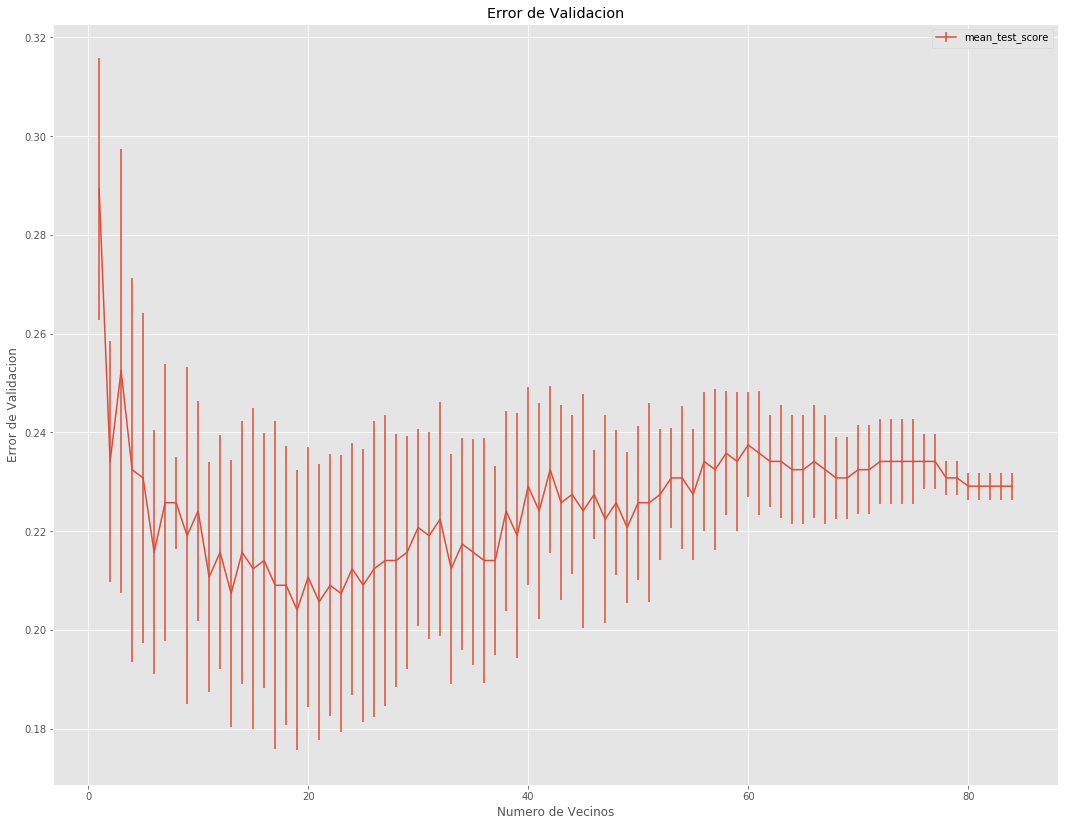

In [256]:
plt.figure(figsize=(18, 14))

plt.title("Error de Validacion")
plt.errorbar(cv_results['param_n_neighbors'], 1 - cv_results['mean_test_score'], cv_results['std_test_score'])
plt.xlabel("Numero de Vecinos")
plt.ylabel("Error de Validacion")
plt.legend(loc='upper right')
plt.show()

Datos del Hiperparámetro con menor error de validación cruzada

In [257]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, ['param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

param_n_neighbors  mean_test_score  std_test_score  rank_test_score
18                19         0.795987         0.02839                1

In [258]:
# Mejor modelo y su error de validación cruzada
best_params = modelCV.best_params_
best_score = 1 - modelCV.best_score_
best_std = modelCV.cv_results_['std_test_score'][modelCV.best_index_]
print("Mejor hiperparámetro: {}".format(best_params))
print("Mejor valor: {}".format(modelCV.best_score_))
print("Menor error de validación cruzada: {}".format(best_score))
print("Menor desviación estandar: {}".format(best_std))

Mejor hiperparámetro: {'n_neighbors': 19}
Mejor valor: 0.795986622074
Menor error de validación cruzada: 0.204013377926
Menor desviación estandar: 0.0283901570211


Si aplicamos la regla de una desviación típica, calculamos otra vez el mejor valor:

In [259]:
threshold = best_score + best_std

suitable_models = [(params, 1 - score) for params, score in zip(modelCV.cv_results_['params'], modelCV.cv_results_['mean_test_score']) if 1 - score <= threshold]

simpler_model = max(suitable_models, key=lambda x: x[0]['n_neighbors'])
    
simpler_model

({'n_neighbors': 84}, 0.22909698996655514)

#### Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del Aprendizaje Estadístico error de test. ¿Cuál es el error de test para el valor del hiper-parámetro seleccionado por la validación cruzada?

Primero calculamos el error para cada valor de k

In [260]:
test_errors = []
for params in modelCV.cv_results_['params']:
    model = KNeighborsClassifier(**params)
    model.fit(X_train_scaled, Y_train)
    Y_pred_test = model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(Y_test, Y_pred_test)
    test_errors.append(test_error)

# Obtener los resultados de validación cruzada
test_results = pd.DataFrame(modelCV.cv_results_)
test_results.loc[:, ['param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                  1         0.710702        0.026454               84
1                  2         0.765886        0.024486               68
2                  3         0.747492        0.044952               83
3                  4         0.767559        0.038894               60
4                  5         0.769231        0.033503               53
5                  6         0.784281        0.024733               20
6                  7         0.774247        0.028078               37
7                  8         0.774247        0.009305               37
8                  9         0.780936        0.034107               26
9                 10         0.775920        0.022319               33
10                11         0.789298        0.023304                9
11                12         0.784281        0.023683               20
12                13         0.792642        0.027109                3
13                14         0.784281        0.026604               20
14                15         0.787625        0.032478               11
15                16         0.785953        0.025775               15
16                17         0.790970        0.033209                5
17                18         0.790970        0.028277                5
18                19         0.795987        0.028390                1
19                20         0.789298        0.026287                9
20                21         0.794314        0.027953                2
21                22         0.790970        0.026540                5
22                23         0.792642        0.028018                3
23                24         0.787625        0.025488               11
24                25         0.790970        0.027686                5
25                26         0.787625        0.030021               11
26                27         0.785953        0.029391               15
27                28         0.785953        0.025642               15
28                29         0.784281        0.023631               20
29                30         0.779264        0.019868               29
..               ...              ...             ...              ...
54                55         0.772575        0.013204               43
55                56         0.765886        0.014154               68
56                57         0.767559        0.016244               60
57                58         0.764214        0.012623               80
58                59         0.765886        0.014154               68
59                60         0.762542        0.010617               82
60                61         0.764214        0.012623               80
61                62         0.765886        0.009314               68
62                63         0.765886        0.011390               68
63                64         0.767559        0.011053               60
64                65         0.767559        0.011053               60
65                66         0.765886        0.011390               68
66                67         0.767559        0.011053               60
67                68         0.769231        0.008226               53
68                69         0.769231        0.008226               53
69                70         0.767559        0.008990               60
70                71         0.767559        0.008990               60
71                72         0.765886        0.008574               68
72                73         0.765886        0.008574               68
73                74         0.765886        0.008574               68
74                75         0.765886        0.008574               68
75                76         0.765886        0.005527               68
76                77         0.765886        0.005527               68
77                78         0.769231        0.003386               53
78                79       

Ahora podemos dibujar la gráfica

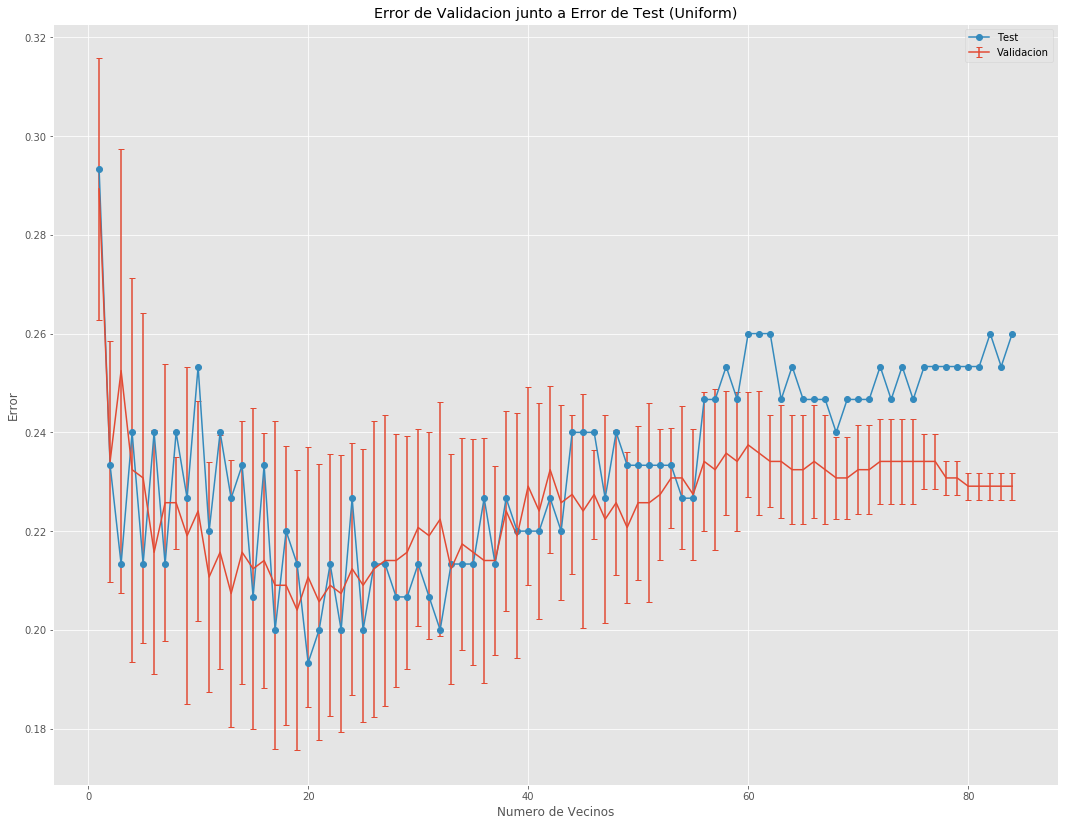

In [261]:
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_title("Error de Validacion junto a Error de Test (Uniform)")
ax.errorbar(cv_results['param_n_neighbors'], 1 - cv_results['mean_test_score'], yerr=cv_results['std_test_score'], label='Validacion', capsize=3)
ax.plot(cv_results['param_n_neighbors'], test_errors, label='Test', marker='o')
ax.set_xlabel("Numero de Vecinos")
ax.set_ylabel("Error")
ax.legend(loc='upper right')
plt.show()

Ahora podemos extraer el valor del error de test para K=19, el que obtuvo el mejor error

In [262]:
best_model_test_error = test_errors[modelCV.best_index_]
print("Error de test para el mejor modelo seleccionado por validación cruzada: {}".format(best_model_test_error))

Error de test para el mejor modelo seleccionado por validación cruzada: 0.213333333333


Tambien podemos hacer lo mismo para el valor de error con la regla de desviación típica

In [263]:
best_model_test_error = test_errors[83]
print("Error de test para el mejor modelo seleccionado por validación cruzada con la regla de desviación típica: {}".format(best_model_test_error))

Error de test para el mejor modelo seleccionado por validación cruzada con la regla de desviación típica: 0.26


Y con el mejor valor de test, k=20

In [264]:
best_model_test_error = test_errors[20]
print("Error de test para el mejor valor de test: {}".format(best_model_test_error))

Error de test para el mejor valor de test: 0.2


## Ejercicio 3: Repite el ejercicio 2 pero para el problema de regresión Energy Efficiency con la variable de salida (Y2)

Primero vamos a importar, mostrar y estudiar los datos. Especificamos el nombre de las columnas para evitar errores con espacion inesperados.

In [188]:
df_3 = pd.read_csv("EnergyEfficiency.data", 
                      delimiter=DATASET_DELIMITER,
                       skiprows=1,
                       header=None,
                       names=["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y2"])
df_3

X1     X2     X3      X4   X5  X6   X7  X8     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  28.28
5    0.90  563.5  318.5  122.50  7.0   3  0.0   0  25.38
6    0.90  563.5  318.5  122.50  7.0   4  0.0   0  25.16
7    0.90  563.5  318.5  122.50  7.0   5  0.0   0  29.60
8    0.86  588.0  294.0  147.00  7.0   2  0.0   0  27.30
9    0.86  588.0  294.0  147.00  7.0   3  0.0   0  21.97
10   0.86  588.0  294.0  147.00  7.0   4  0.0   0  23.49
11   0.86  588.0  294.0  147.00  7.0   5  0.0   0  27.87
12   0.82  612.5  318.5  147.00  7.0   2  0.0   0  23.77
13   0.82  612.5  318.5  147.00  7.0   3  0.0   0  21.46
14   0.82  612.5  318.5  147.00  7.0   4  0.0   0  21.16
15   0.82  612.5  318.5  147.00  7.0   5  0.0   0  24.93
16   0.79  637.0  343.0  147.00  7.0   2  0.0   0  37.73
17   0.79  637.0  343.0  147.00  7.0   3  0.0   0  31.27
18   0.79  637.0  343.0  147.00  7.0   4  0.0   0  30.93
19   0.79  637.0  343.0  147.00  7.0   5  0.0   0  39.44
20   0.76  661.5  416.5  122.50  7.0   2  0.0   0  29.79
21   0.76  661.5  416.5  122.50  7.0   3  0.0   0  29.68
22   0.76  661.5  416.5  122.50  7.0   4  0.0   0  29.79
23   0.76  661.5  416.5  122.50  7.0   5  0.0   0  29.40
24   0.74  686.0  245.0  220.50  3.5   2  0.0   0  10.90
25   0.74  686.0  245.0  220.50  3.5   3  0.0   0  11.19
26   0.74  686.0  245.0  220.50  3.5   4  0.0   0  10.94
27   0.74  686.0  245.0  220.50  3.5   5  0.0   0  11.17
28   0.71  710.5  269.5  220.50  3.5   2  0.0   0  11.27
29   0.71  710.5  269.5  220.50  3.5   3  0.0   0  11.72
..    ...    ...    ...     ...  ...  ..  ...  ..    ...
738  0.79  637.0  343.0  147.00  7.0   4  0.4   5  47.01
739  0.79  637.0  343.0  147.00  7.0   5  0.4   5  44.87
740  0.76  661.5  416.5  122.50  7.0   2  0.4   5  39.37
741  0.76  661.5  416.5  122.50  7.0   3  0.4   5  39.80
742  0.76  661.5  416.5  122.50  7.0   4  0.4   5  37.79
743  0.76  661.5  416.5  122.50  7.0   5  0.4   5  38.18
744  0.74  686.0  245.0  220.50  3.5   2  0.4   5  16.69
745  0.74  686.0  245.0  220.50  3.5   3  0.4   5  16.62
746  0.74  686.0  245.0  220.50  3.5   4  0.4   5  16.94
747  0.74  686.0  245.0  220.50  3.5   5  0.4   5  16.70
748  0.71  710.5  269.5  220.50  3.5   2  0.4   5  15.59
749  0.71  710.5  269.5  220.50  3.5   3  0.4   5  14.58
750  0.71  710.5  269.5  220.50  3.5   4  0.4   5  15.33
751  0.71  710.5  269.5  220.50  3.5   5  0.4   5  15.31
752  0.69  735.0  294.0  220.50  3.5   2  0.4   5  16.63
753  0.69  735.0  294.0  220.50  3.5   3  0.4   5  15.87
754  0.69  735.0  294.0  220.50  3.5   4  0.4   5  16.54
755  0.69  735.0  294.0  220.50  3.5   5  0.4   5  16.74
756  0.66  759.5  318.5  220.50  3.5   2  0.4   5  17.64
757  0.66  759.5  318.5  220.50  3.5   3  0.4   5  17.79
758  0.66  759.5  318.5  220.50  3.5   4  0.4   5  17.55
759  0.66  759.5  318.5  220.50  3.5   5  0.4   5  18.06
760  0.64  784.0  343.0  220.50  3.5   2  0.4   5  20.82
761  0.64  784.0  343.0  220.50  3.5   3  0.4   5  20.21
762  0.64  784.0  343.0  220.50  3.5   4  0.4   5  20.71
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.03

[768 rows x 9 columns]

In [189]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
X1    768 non-null float64
X2    768 non-null float64
X3    768 non-null float64
X4    768 non-null float64
X5    768 non-null float64
X6    768 non-null int64
X7    768 non-null float64
X8    768 non-null int64
Y2    768 non-null float64
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


Vamos a ver las correlaciones de los datos:

In [190]:
df_3.corr()

X1            X2            X3            X4            X5  \
X1  1.000000e+00 -9.919015e-01 -2.037817e-01 -8.688234e-01  8.277473e-01   
X2 -9.919015e-01  1.000000e+00  1.955016e-01  8.807195e-01 -8.581477e-01   
X3 -2.037817e-01  1.955016e-01  1.000000e+00 -2.923165e-01  2.809757e-01   
X4 -8.688234e-01  8.807195e-01 -2.923165e-01  1.000000e+00 -9.725122e-01   
X5  8.277473e-01 -8.581477e-01  2.809757e-01 -9.725122e-01  1.000000e+00   
X6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
X7  1.283986e-17  1.318356e-16 -7.969726e-19 -1.381805e-16  1.861418e-18   
X8  1.764620e-17 -3.558613e-16  0.000000e+00 -1.079129e-16  0.000000e+00   
Y2  6.343391e-01 -6.729989e-01  4.271170e-01 -8.625466e-01  8.957852e-01   

         X6            X7            X8        Y2  
X1  0.00000  1.283986e-17  1.764620e-17  0.634339  
X2  0.00000  1.318356e-16 -3.558613e-16 -0.672999  
X3  0.00000 -7.969726e-19  0.000000e+00  0.427117  
X4  0.00000 -1.381805e-16 -1.079129e-16 -0.862547  
X5  0.00000  1.861418e-18  0.000000e+00  0.895785  
X6  1.00000  0.000000e+00  0.000000e+00  0.014290  
X7  0.00000  1.000000e+00  2.129642e-01  0.207505  
X8  0.00000  2.129642e-01  1.000000e+00  0.050525  
Y2  0.01429  2.075050e-01  5.052512e-02  1.000000

Hay varios resultados relevantes:
- Las parejas X1-X2 y X4-X5 tienen una correlacion negativa muy cercana a -1, lo que indica que estan inversamente relacionadas casi a la perfección
- Las mayores correlaciones de Y2 son positiva con X5(0.89) y negativa con X4(-0.86) 

No tenemos datos nulos así que podemos proceder. Vamos a dividir los datos en entrada X y salida Y ademas de crear la division de entrenamiento y prueba

In [265]:
X = df_3.drop('Y2', axis=1)
Y = df_3['Y2']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED_VALUE)

Vamos a estandarizar tanto X como Y ya que estamos ante un problema de regresión

In [266]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [267]:
hyperparameters = {'n_neighbors': range(1, 85, 1)}
knn_reg = KNeighborsRegressor()
modelCV = GridSearchCV(
    knn_reg,
    hyperparameters,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1)
modelCV.fit(X_train_scaled, Y_train_scaled)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Ahora tenemos que desestandarizar los datos, multiplicandolos por la varianza de las observaciones de Y del conjunto de entrenamiento

In [268]:
y_train_var = np.var(Y_train)
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results['mean_test_score'] = cv_results['mean_test_score'].abs() * y_train_var
cv_results['std_test_score'] = cv_results['std_test_score'] * y_train_var

Vamos a dibujar la grafica de entrenamiento

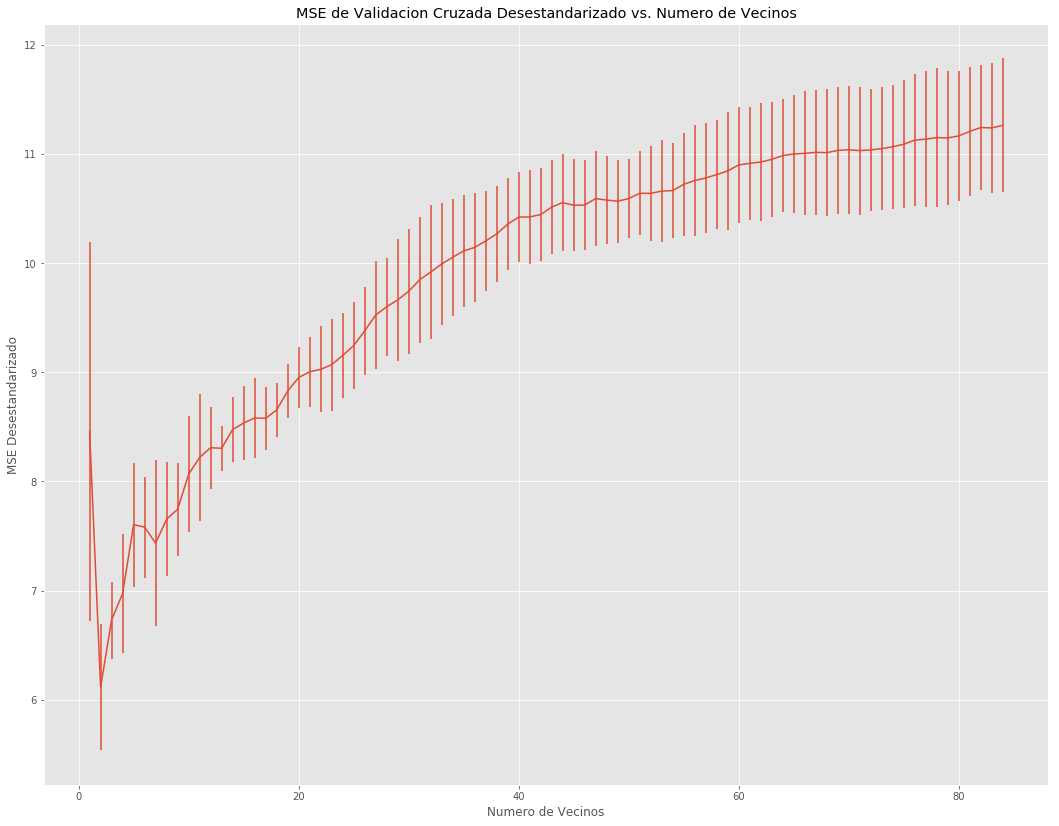

In [269]:
plt.figure(figsize=(18, 14))
plt.errorbar(cv_results['param_n_neighbors'], cv_results['mean_test_score'], yerr=cv_results['std_test_score'])
plt.xlabel('Numero de Vecinos')
plt.ylabel('MSE Desestandarizado')
plt.title('MSE de Validacion Cruzada Desestandarizado vs. Numero de Vecinos')
plt.show()

In [270]:
best_mse = modelCV.best_score_
best_mse_std = modelCV.cv_results_['std_test_score'][modelCV.best_index_]
optimal_n_neighbors = modelCV.best_params_['n_neighbors']

print("Mejor hiperparámetro: {}".format(optimal_n_neighbors))
print("El menor error de validación cruzada (MSE) es: {}".format(-best_mse))
print("La desviación estándar del menor error de validación cruzada es: {}".format(best_mse_std))

Mejor hiperparámetro: 2
El menor error de validación cruzada (MSE) es: 0.0684371726349
La desviación estándar del menor error de validación cruzada es: 0.00646792705277


In [271]:
best_model = modelCV.best_estimator_
Y_pred_test_scaled = best_model.predict(X_test_scaled)
Y_pred_test = scaler_Y.inverse_transform(Y_pred_test_scaled.reshape(-1, 1)).flatten()
test_mse = mean_squared_error(Y_test, Y_pred_test)
print("MSE de test desestandarizado para el mejor modelo: {}".format(test_mse))

MSE de test desestandarizado para el mejor modelo: 12.5886563312


Ahora vamos a calcular cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar

In [272]:
threshold = -best_mse + best_mse_std

suitable_models = modelCV.cv_results_['mean_test_score'] >= -threshold
suitable_indices = np.where(suitable_models)[0]

simpler_model_index = suitable_indices[-1]
simpler_n_neighbors = modelCV.cv_results_['param_n_neighbors'][simpler_model_index]
simpler_model_error = -modelCV.cv_results_['mean_test_score'][simpler_model_index]
simpler_model_std = modelCV.cv_results_['std_test_score'][simpler_model_index]

print("Modelo más simple con la desviación típica:")
print("Mejor hiperparámetro: {}".format(simpler_n_neighbors))
print("El menor error de validación cruzada (MSE) es: {}".format(simpler_model_error))
print("La desviación estándar del menor error de validación cruzada es: {}".format(simpler_model_std))

Modelo más simple con la desviación típica:
Mejor hiperparámetro: 2
El menor error de validación cruzada (MSE) es: 0.0684371726349
La desviación estándar del menor error de validación cruzada es: 0.00646792705277


Con todo esto estudiado, ahora podemos dibujar la grafica del error de test frente al valor del hiper‐parámetro

In [273]:
test_errors = []
for k in range(1, 85):  
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, Y_train_scaled)  
    Y_pred_test_scaled = model.predict(X_test_scaled)
    Y_pred_test = scaler_Y.inverse_transform(Y_pred_test_scaled.reshape(-1, 1)).flatten()
    mse = mean_squared_error(Y_test, Y_pred_test)
    test_errors.append(mse)

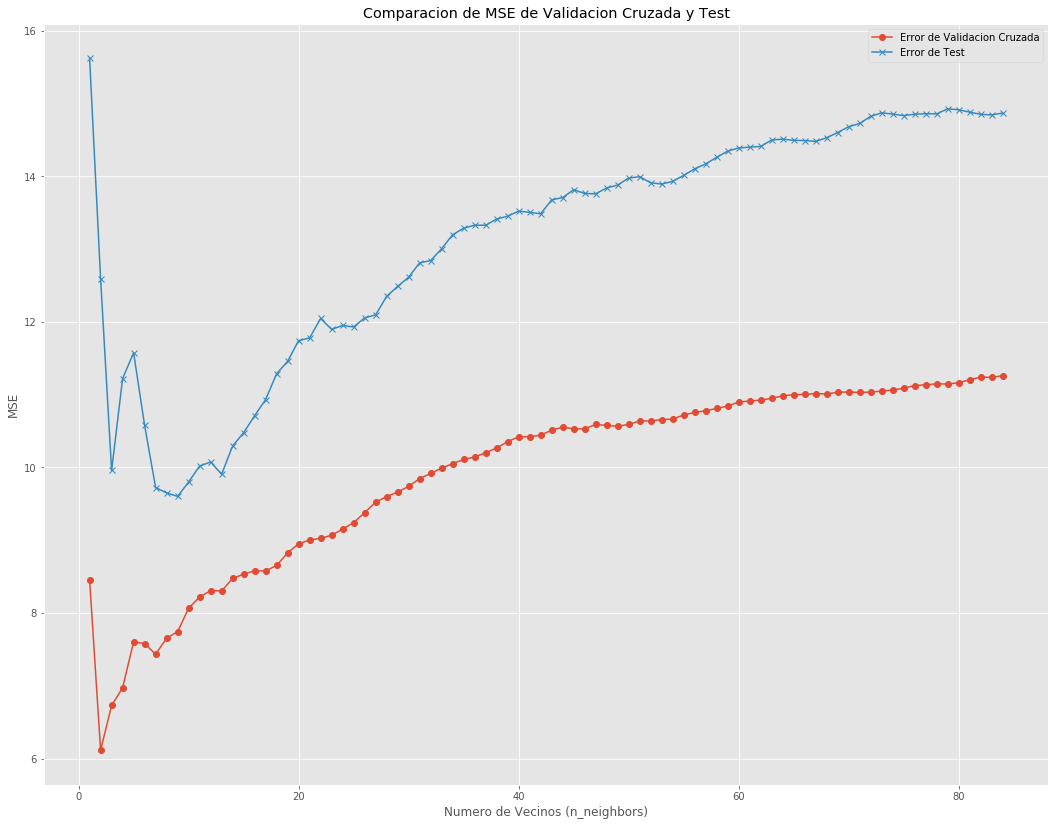

In [274]:
plt.figure(figsize=(18, 14))
plt.plot(range(1, 85), cv_results['mean_test_score'], label='Error de Validacion Cruzada', marker='o')
plt.plot(range(1, 85), test_errors, label='Error de Test', marker='x')
plt.xlabel('Numero de Vecinos (n_neighbors)')
plt.ylabel('MSE')
plt.title('Comparacion de MSE de Validacion Cruzada y Test')
plt.legend()
plt.show()

Vamos a consultar el error de test para el valor del hiper-parámetro seleccionado por la validación cruzada

In [280]:
best_model_test_error = test_errors[modelCV.best_index_]
print("Error de test para el mejor modelo seleccionado por validación cruzada: {}".format(best_model_test_error))

Error de test para el mejor modelo seleccionado por validación cruzada: 12.5886563312


Y para el mejor valor de MSE:

In [283]:
best_model_test_error = test_errors[9]
print("Error de test para el mejor valor de MSE: {}".format(best_model_test_error))

Error de test para el mejor valor de MSE: 9.80006677922
